# LeNet5

In [51]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

class LeNet5Model(nn.Module):

    def __init__(self):
        super(LeNet5Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1)
        self.conv1_act = nn.Tanh()
        self.conv1_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv2_act = nn.Tanh()
        self.conv2_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.conv3_act = nn.Tanh()

        self.fc = nn.Linear(in_features=120, out_features=84)
        self.fc_act = nn.Tanh()

        self.fc_out = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1_act = self.conv1_act(conv1)
        pool1 = self.conv1_pool(conv1_act)

        conv2 = self.conv2(pool1)
        conv2_act = self.conv2_act(conv2)
        pool2 = self.conv2_pool(conv2_act)
        conv3 = self.conv3(pool2)
        conv3_act = self.conv3_act(conv3).view(-1, 120)

        fc = self.fc(conv3_act)
        fc_act = self.fc_act(fc)
        fc_out = self.fc_out(fc_act)
        return fc_out

shape = (8, 1, 28, 28)
test_data = torch.randn(torch.prod(torch.tensor(shape))).reshape(shape)
print(test_data.shape)
model = LeNet5Model()
result = model(test_data)
print(f"result shape = {result.shape}")

torch.Size([8, 1, 28, 28])
result shape = torch.Size([8, 10])


In [97]:
class ReshapeModule(nn.Module):
    def __init__(self, shape):
        super(ReshapeModule, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(*self.shape)

class LeNet5SequentialModel(nn.Module):

    def __init__(self):
        super(LeNet5SequentialModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
            # ReshapeModule(shape=(-1, 120))
        )

        self.classifier_layers = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        conv = self.conv_layers(x)
        reshape_conv = conv.view(-1, 120)
        out = self.classifier_layers(reshape_conv)
        return out

# MNIST learning

In [96]:
from torch.optim import SGD
from tqdm import tqdm

seed = 42
BATCH_SIZE = 8
EPOCHS = 10
LR = 0.1
torch.manual_seed(seed)
data = MNIST(root="data", download=True, train=True, transform=ToTensor())
len_data = len(data)
dataloader = DataLoader(dataset=data, batch_size=BATCH_SIZE)
DEVICE = "cpu"

model = LeNet5SequentialModel()
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

epoch_losses, epoch_accs = [], []

for epoch in range(EPOCHS):
    epoch_loss, epoch_acc = 0., 0
    print(f"Epoch {epoch+1}")
    for X, Y in tqdm(dataloader, desc="진행중"):
        X, Y = X.to(DEVICE), Y.to(DEVICE)

        pred = model(X)

        # cross entropy loss
        loss = loss_function(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실
        epoch_loss += loss.item() * len(X)

        # 정확도
        pred_max_indices = torch.argmax(pred, axis=1)
        corrects = (pred_max_indices == Y).sum()
        epoch_acc += corrects

    epoch_losses.append(epoch_loss / len_data)
    epoch_accs.append(epoch_acc / len_data)

Epoch 1


진행중: 100%|██████████| 7500/7500 [00:55<00:00, 136.33it/s]


Epoch 2


진행중: 100%|██████████| 7500/7500 [00:52<00:00, 142.02it/s]


Epoch 3


진행중: 100%|██████████| 7500/7500 [00:54<00:00, 136.60it/s]


Epoch 4


진행중: 100%|██████████| 7500/7500 [00:52<00:00, 141.60it/s]


Epoch 5


진행중: 100%|██████████| 7500/7500 [00:50<00:00, 149.06it/s]


Epoch 6


진행중: 100%|██████████| 7500/7500 [00:53<00:00, 139.19it/s]


Epoch 7


진행중: 100%|██████████| 7500/7500 [00:52<00:00, 142.40it/s]


Epoch 8


진행중: 100%|██████████| 7500/7500 [00:51<00:00, 145.90it/s]


Epoch 9


진행중: 100%|██████████| 7500/7500 [00:52<00:00, 144.00it/s]


Epoch 10


진행중: 100%|██████████| 7500/7500 [00:51<00:00, 144.83it/s]


### visualization

Text(0.5, 0, 'Epoch')

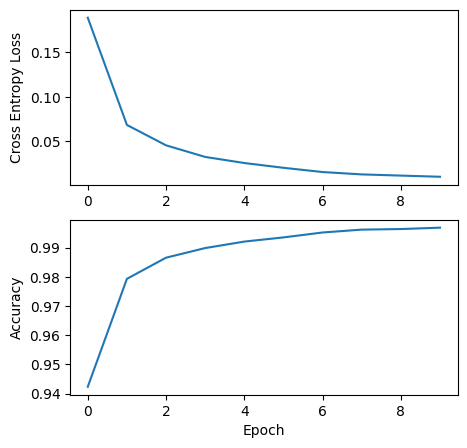

In [83]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))

axes[0].plot(range(len(epoch_losses)), epoch_losses)
axes[0].set_ylabel("Cross Entropy Loss")
axes[1].plot(range(len(epoch_accs)), epoch_accs)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")

### torchsummary

In [89]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
     ReshapeModule-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             Tanh-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------